# Loading ADD dataset

Here, we are using [PyTorch's `Dataset` class](https://pytorch.org/docs/stable/data.html). [Skimage's](https://scikit-image.org/) `io`  and `draw` are employed on image reading and bounding box visualizations.

In [1]:
import json
import os
import numpy as np
import random

from skimage import draw
from skimage import io as skio

from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
class AppleFromDronesDetectionDataset(Dataset):

    def __init__(self, json_file, image_dir , transform=None, image_size=256):
        """
        Args:
            json_file (string): Path to the JSON file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional data augmentation to be applied
                on a sample.
        """

        self.images_dir = image_dir
        
        with open(json_file, 'r') as fp:
            json_str = ''.join(fp.readlines())

        self.annotations = json.loads(json_str)
        self.image_list = list(self.annotations.keys())        
        self.transform = transform
        self.boxes = list()
        
        for image_name in self.image_list:
            annot = self.annotations[image_name]
            boxes = list()
            for apple in annot:
                cx, cy, r = apple['cx'], apple['cy'], apple['r']
                x0, x1 = max(cx - r, 0), min(cx + r, image_size-1)
                y0, y1 = max(cy - r, 0), min(cy + r, image_size-1)
                boxes.append((x0, y0, x1, y1))
                
            self.boxes.append(np.array(boxes))
            
        self._num_apples = None
        

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        
        image_id = f'{idx:05d}:{self.image_list[idx]}'
        image_path = os.path.join(self.images_dir, self.image_list[idx])
        image = skio.imread(image_path)
        boxes = self.boxes[idx]
        n_boxes = boxes.shape[0]

        if self.transform:
            # Albumentations can transform images and boxes
            transformed = self.transform(image=image, 
                                         bboxes=boxes, 
                                         class_labels=["apple"] * len(boxes)) 
            image = transformed["image"]
            boxes = transformed["bboxes"]

        labels = torch.ones((n_boxes, ), dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id
        }
            
        return image, target, image_id
    
    def num_apples(self):
        if self._num_apples is not None:
            return self._num_apples
        
        acc = 0
        for boxes in self.boxes:
            acc += boxes.shape[0]
            
        self._num_apples = acc
        return self._num_apples    

In [3]:
train_dataset = AppleFromDronesDetectionDataset('./training.json', './images', transform=None)
test_dataset = AppleFromDronesDetectionDataset('./test.json', './images', transform=None)

## Sanity check

In [4]:
n_train = len(train_dataset)
n_train

1025

In [5]:
n_test = len(test_dataset)
n_test

114

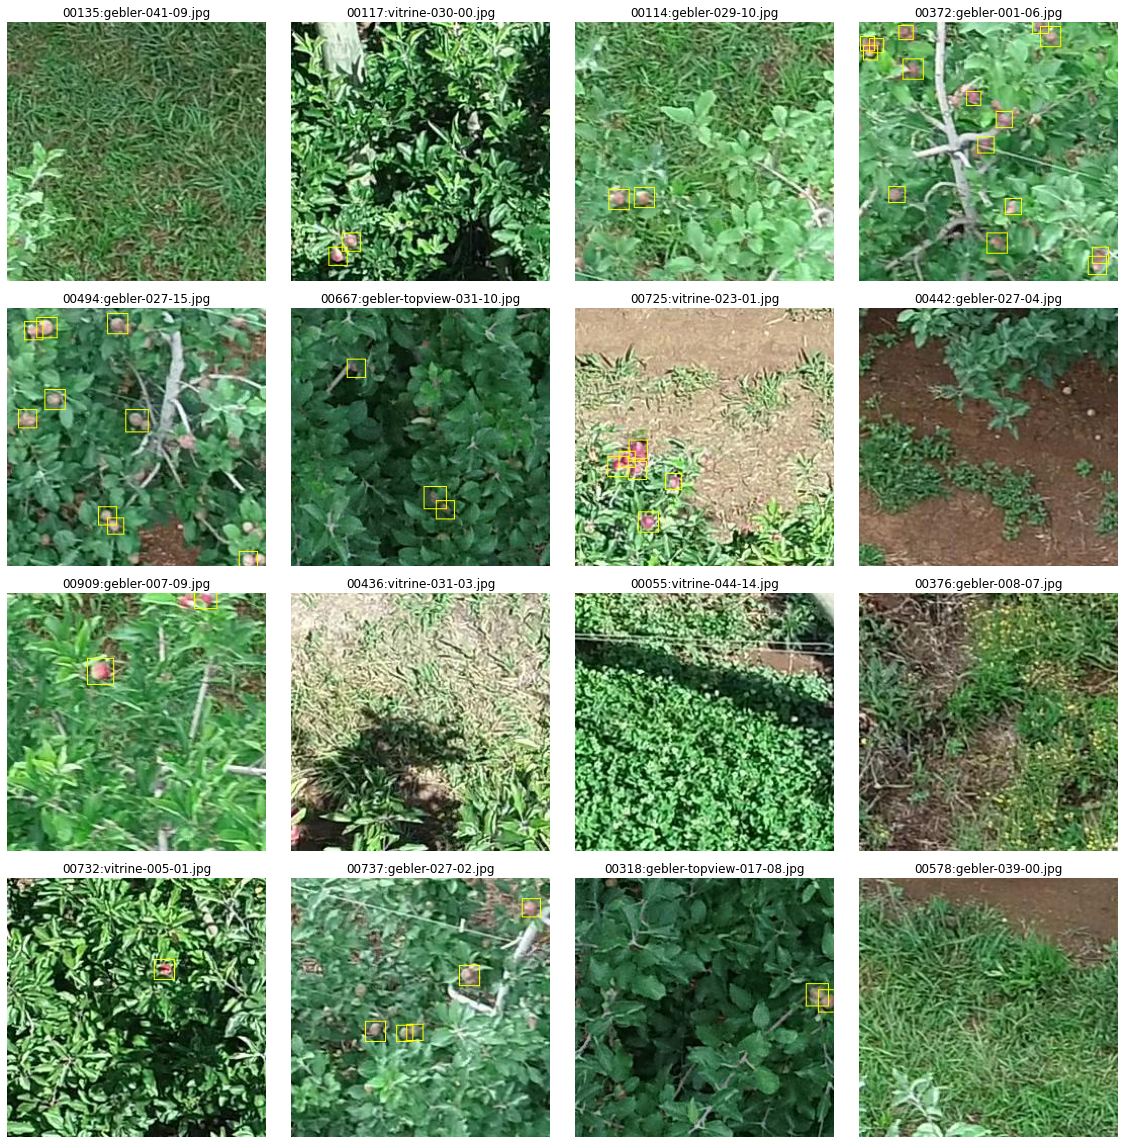

In [6]:
fig, axs = plt.subplots(figsize=(16, 16), nrows=4, ncols=4)
axs = axs.reshape(-1)
YELLOW = (255, 255, 0)

for (img, target, img_id), ax in zip(random.choices(train_dataset, k=16), axs):
    
    display_img = img.copy()
    for (x0, y0, x1, y1) in target['boxes']:
        rr, cc = draw.rectangle_perimeter(start=(y0, x0), end=(y1, x1), shape=img.shape)
        display_img[rr, cc] = YELLOW
    
    ax.imshow(display_img)
    ax.set_title(img_id)
    ax.axis('off')
    
fig.tight_layout()

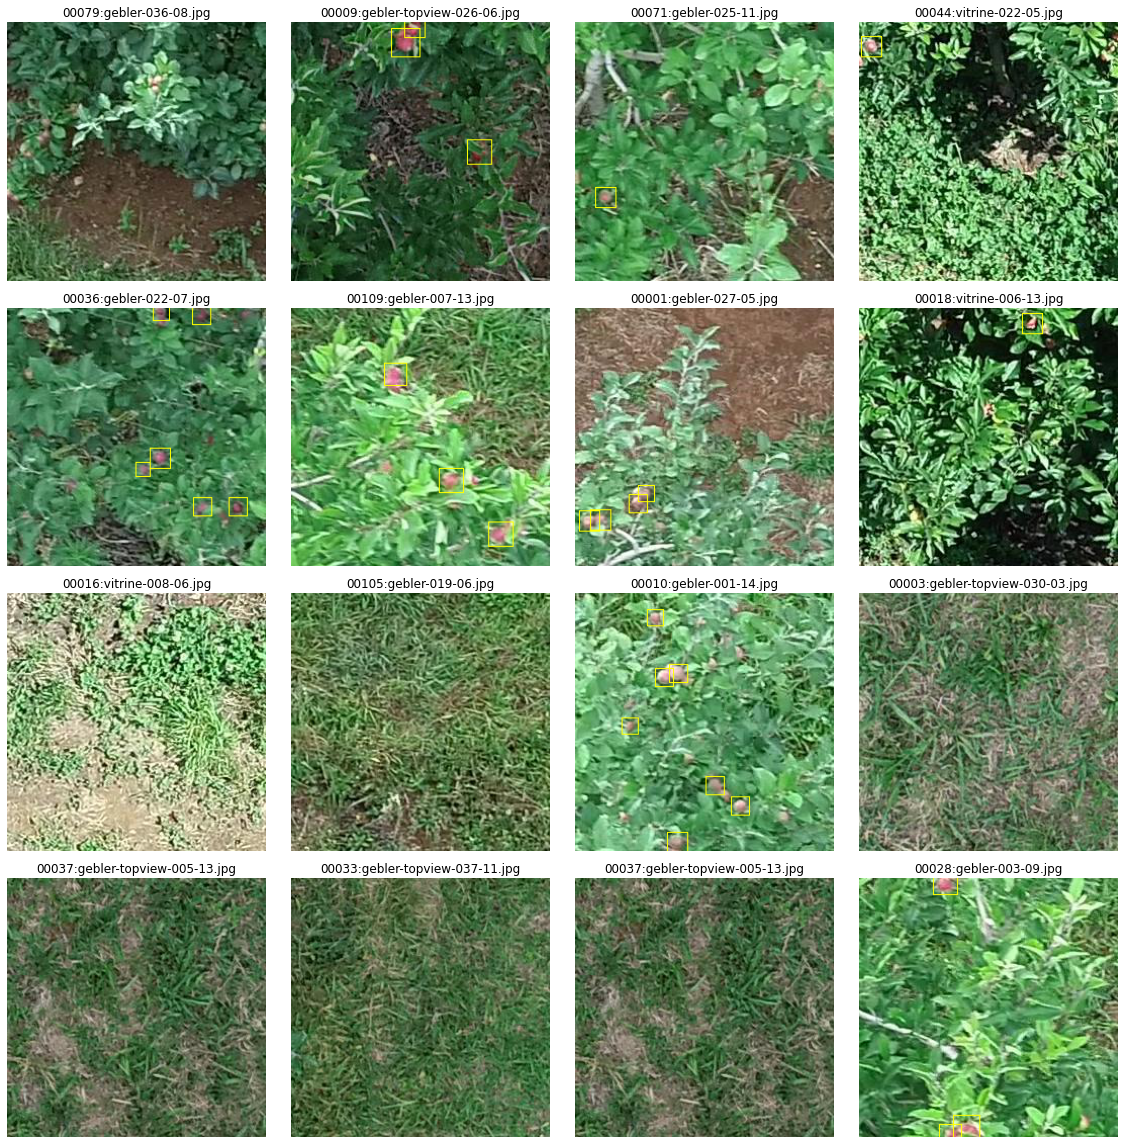

In [7]:
fig, axs = plt.subplots(figsize=(16, 16), nrows=4, ncols=4)
axs = axs.reshape(-1)
YELLOW = (255, 255, 0)

for (img, target, img_id), ax in zip(random.choices(test_dataset, k=16), axs):
    
    display_img = img.copy()
    for (x0, y0, x1, y1) in target['boxes']:
        rr, cc = draw.rectangle_perimeter(start=(y0, x0), end=(y1, x1), shape=img.shape)
        display_img[rr, cc] = YELLOW
    
    ax.imshow(display_img)
    ax.set_title(img_id)
    ax.axis('off')
    
fig.tight_layout()

In [8]:
train_dataset.num_apples()

2204

In [9]:
test_dataset.num_apples()

267